# Setup everything

### Do imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# --- Import modules --- #
import numpy as np
import matplotlib.pyplot as plt

import os 
import os.path as op
import sys
import mne
from mne import pick_types, find_layout
from mne.io import read_info
from mne.viz import plot_topomap
from mne import stats as st
from custom_stats import *
from load_data import read_info_custom, LoadAutGamma

### Setup parameters

In [4]:
# ---------- Setup stuff for plotting  ------------ #
# info needed to get sensors positions
# For .ds files info in a case of missing channel should 
# pick info_file with 271 meg channels, not 272


#                            | CHANGE THIS  |
#                           \/             \/
info_file = '/media/karim/SSD500/aut_gamma/K0001/K0001/K0001ec-epo.fif' 
#                      /\   /\   /\   /\   /\   /\
#                      |    |    |    |    |    |
# ----------------------------------------------------------------------- #
    
info = read_info_custom(info_file)   # <-- works both with ctf and electa
layout = find_layout(info)           # <-- Get sensor positions. 

fsize = (16,7)
mask_params = dict(marker='*', markerfacecolor='m', markersize=10) # significant sensors appearence

IOError: [Errno 2] No such file or directory: '/media/karim/SSD500/aut_gamma/K0001/K0001/K0001ec-epo.fif'

In [ ]:
# ----------- ONLY FOR ELECTA (.fif) ------------- #

# --- Setup indexing for different sensor types --- #
# For ctf data this should be changed #
grads1 = pick_types(info, meg='planar1')
grads2 = pick_types(info, meg='planar2')
mags   = pick_types(info, meg='mag')
grads  = pick_types(info, meg='grad')

ch_used = grads
sensors_pos = layout.pos[ch_used]
# ------------------------------------------------- #

# Interesting stuff starts here

### Load data 

In [57]:
ep_path = '/media/karim/SSD500/aut_gamma/Moscow_baseline_results_new/'
subj_names = dict()
subj_names['K'] = [s for s in os.listdir(ep_path) if len(s) == 5 and s.startswith('K')]
subj_names['R'] = [s for s in os.listdir(ep_path) if len(s) == 5 and s.startswith('R')]

In [58]:
# --------------- LOAD DATA --------------------- #
# This cell is dataset-specific.
# Load data for power statistical analysis for scz ctf dataset
# can be changed to plot connectivity. 
# Define paths to two folders which 
# contain data for two conditions we want to compare and load the data

# PREDEFINE:
# miss_ch_id       - missing channel 
# LoadSczPowerData - data loading function

# --------------------------------------------------------------- #
conds = ('ec', 'eo')
bands = ('delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma')
groups = ('K', 'R')

# --------------------------------------------------------------- #
basedir = '/media/karim/SSD500/aut_gamma/powers'

data = dict()
fnames = dict()

# ----------- Load all the data ------------ #
for cond in conds:
    data[cond] = dict()
    fnames[cond] = dict()    
    for band in bands:
        data[cond][band] = dict()
        fnames[cond][band] = dict()
        for group in groups:
            subdir = cond + '_' + band
            cond_dir = op.join(basedir, subdir, group)
            cond_data, cond_fnames = LoadAutGamma(cond_dir, subj_names[group])
            
#             #  ---- Mask bad subjects ---- #
#             bads_mask = np.array([subj_name in bad_subjects[cond] for subj_name in subj_names[group]])
#             cond_data.mask[bads_mask,:] = True
#             cond_fnames.mask[bads_mask] = True
            
            data[cond][band][group]  = cond_data
            fnames[cond][band][group] = cond_fnames
            
# ----------------------------------------- #
# print fnames['Closed']['alpha']['Controls']
# cond1_data = data['-------Closed']['alpha'][]

In [59]:
def rm_masked(masked_data):
    return masked_data.data[~np.all(masked_data.mask, axis=1),:]

In [60]:
cond = 'ec'
band = 'lowgamma'

cond1_data =  rm_masked(data[cond][band]['K'])
cond1_data = cond1_data[:,ch_used]
fnames1 = fnames[cond][band]['K'].compressed()

cond2_data = rm_masked(data[cond][band]['R'])
cond2_data = cond2_data[:,ch_used]
fnames2 = fnames[cond][band]['R'].compressed()
# fnames1.shape

In [90]:
# Look at reactivity
band = 'lowgamma'
cond1_data = rm_masked(data['eo'][band]['K'] - data['ec'][band]['K'])
cond1_data = cond1_data[:,ch_used]

cond2_data = rm_masked(data['eo'][band]['R'] - data['ec'][band]['R'])
cond2_data = cond2_data[:,ch_used]


In [91]:
# Do normalization

# No normalization
cond1_data_norm = cond1_data
cond2_data_norm = cond2_data

# By mean
# cond1_data_norm = cond1_data / cond1_data.mean(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.mean(axis=1)[:,None]

# By max
# cond1_data_norm = cond1_data / cond1_data.max(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.max(axis=1)[:,None]

# Z-scores
# cond1_data_norm = (cond1_data - cond1_data.mean(axis=1)[:,None]) / cond1_data.std(axis=1)[:,None]
# cond2_data_norm = (cond2_data - cond2_data.mean(axis=1)[:,None]) / cond2_data.std(axis=1)[:,None]

In [92]:
# ----- statistical mask setup --------- #
thresh = 0.05
# thresh = 0.01

# stat_test_func = fdr(no_corr_mannwhitneyu)
# stat_test_func = no_corr_mannwhitneyu
# stat_test_func = fdr(unpair_no_corr_t_test)
stat_test_func = unpair_no_corr_t_test
# stat_test_func = unpair_clust_f_test
# stat_test_func = fdr(unpair_no_corr_perm_t_test)

mask, p_vals = GetStatMask(cond1_data_norm, cond2_data_norm, stat_test_func=stat_test_func, p_thresh=thresh)
print 'Indices of significant sensors:', [i for i in xrange(len(p_vals)) if p_vals[i] < thresh]
# p_vals

Indices of significant sensors: []


CONDITION: ec, BAND: lowgamma


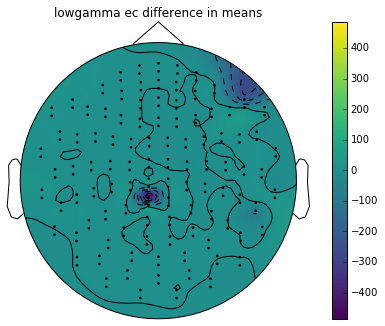

In [93]:
# Plot mean difference and the variance of this difference between groups
print 'CONDITION: {}, BAND: {}'.format(cond, band)

# Relative change in mean:
data_mean = np.divide(cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0), cond1_data_norm.mean(axis=0)) 
# data_mean = cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0)
fig = plt.figure(figsize=(8,5))

# Plot diff of means
ax,_ = plot_topomap(data_mean, sensors_pos, mask=mask, mask_params=mask_params,
                    cmap='viridis', show=False)#, vmin=-2.4e-27, vmax=2.4e-27)
plt.title(band + ' ' + cond + ' ' + 'difference in means')
fig.colorbar(ax)#, shrink=0.2)

plt.show()
plt.close(fig)

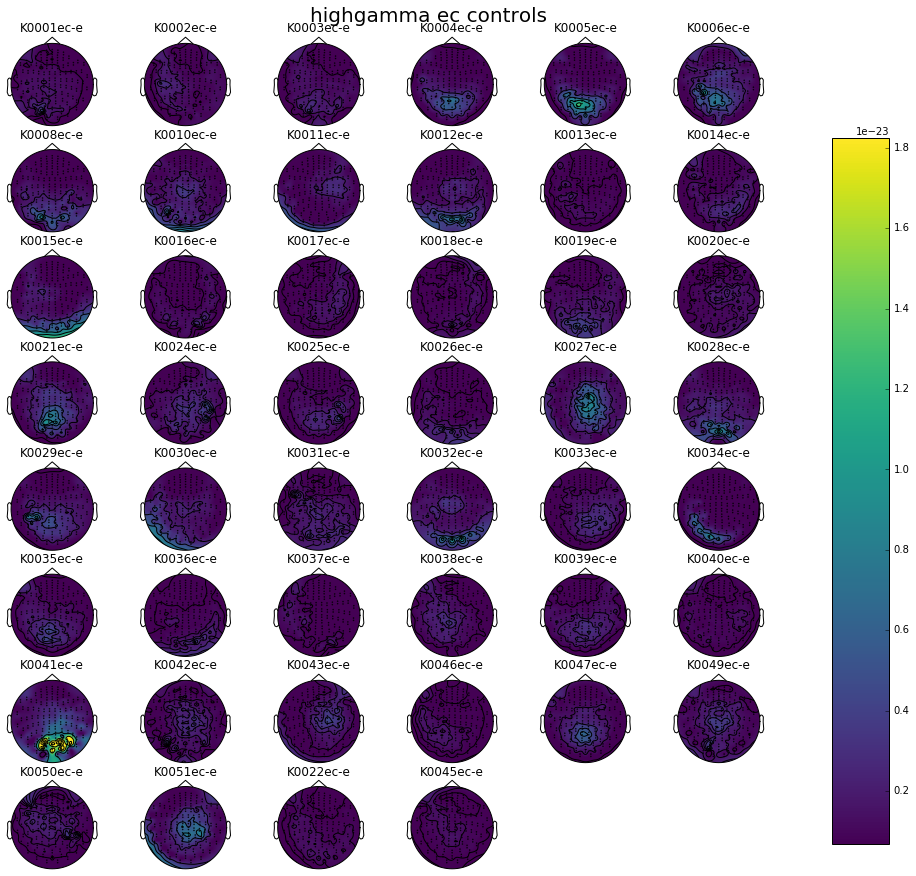

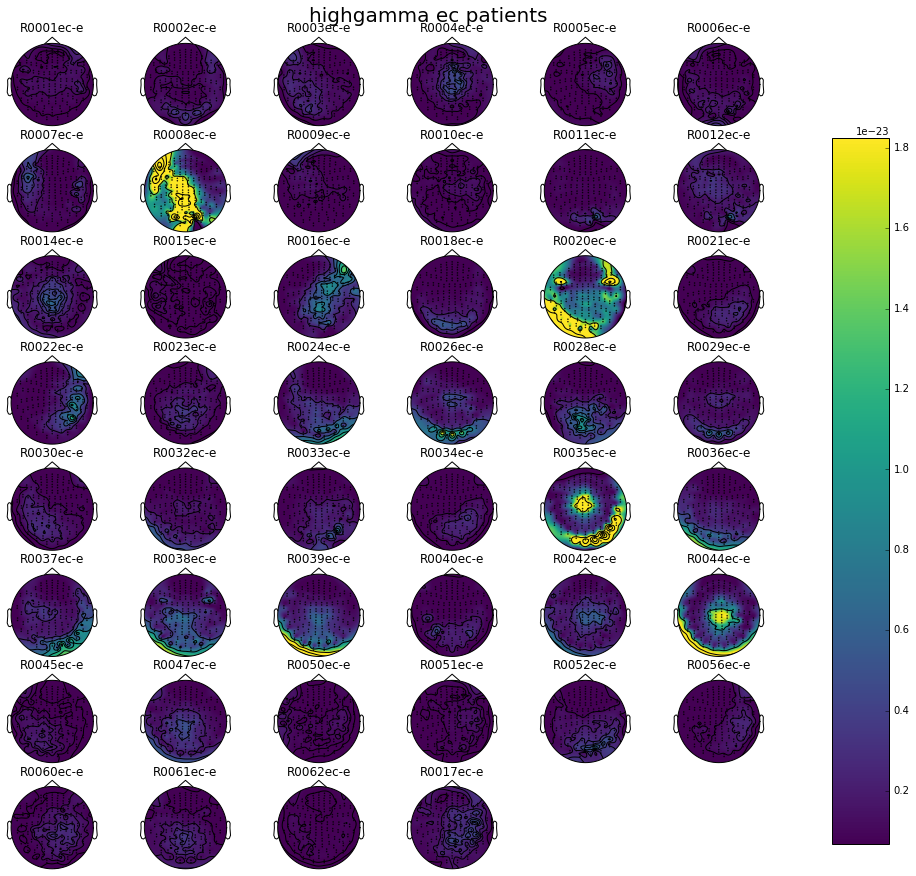

In [96]:
# Plot all cond
vmin = min(cond1_data_norm.min(), cond2_data_norm.min()) * 5
vmax = max(cond1_data_norm.max(), cond2_data_norm.max()) / 5


for cond_data_norm,  fn, group in zip((cond1_data_norm, cond2_data_norm), (fnames1, fnames2), ('controls', 'patients')):
    n_iter = cond_data_norm.shape[0]
    subj_names = map(lambda s: s[:9], fn)
    fig = plt.figure(figsize=(14,14))
    # fig, axes = plt.subplots(nrows=25, ncols=25, sharex=True, sharey=True)
    fig.set_size_inches(16,14)

    for i in range(n_iter):
        plt.subplot(8,6,i + 1)
        ax = plt.gca()
        data_i = cond_data_norm[i,:]
        im,_ = plot_topomap(data_i, sensors_pos, cmap='viridis', show=False, vmin=vmin, vmax=vmax)
        title = subj_names[i]
        plt.title(title)
    main_title = band + ' ' + cond + ' ' + group 
    plt.suptitle(main_title, fontsize=20)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    plt.close(fig) 